# 02 - Обзор основных алгоритмов Boosting 

In [1]:
if 0:
    !pip install -U xgboost
    !pip install -U lightgbm
    !pip install -U catboost

In [2]:
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# pd.set_option('display.max_columns', None)
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

#### Загрузка данных

In [4]:
DATA_TRAIN = "../data/02/assignment_2_train.csv"
DATA_TEST = "../data/02/assignment_2_test.csv"

In [5]:
data = pd.read_csv(DATA_TRAIN)
print("data.shape = {} rows, {} cols".format(*data.shape))
data.head(n=2)

data.shape = 180000 rows, 394 cols


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
test_data = pd.read_csv(DATA_TEST)
print("data_test.shape = {} rows, {} cols".format(*test_data.shape))
test_data.head(n=2)

data_test.shape = 100001 rows, 394 cols


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3287000,1,7415038,226.0,W,12473,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3287001,0,7415054,3072.0,W,15651,417.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Быстрый просмотр данных

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 541.1+ MB


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100001 entries, 0 to 100000
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 300.6+ MB


In [9]:
ID_F = 'TransactionID'
TARGET_F = 'isFraud'
DT_F = 'TransactionDT'
NUMERICAL_F = data.select_dtypes(include=[np.number]).columns.drop([TARGET_F, ID_F])
CAT_F = data.select_dtypes(include='object').columns

In [10]:
NUMERICAL_F

Index(['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5',
       'addr1', 'addr2', 'dist1', 'dist2',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=378)

In [11]:
CAT_F

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'],
      dtype='object')

In [12]:
# pd.to_timedelta(tr_data[DT_F], unit='s')

### Подготовка данных для моделей

In [13]:
target = data[TARGET_F]
train_df = data.drop([ID_F, TARGET_F], axis=1)
print("tr_df.shape = {} rows, {} cols".format(*train_df.shape))

tr_df.shape = 180000 rows, 392 cols


#### Числовые данные

In [14]:
def make_numeric_df(df: pd.DataFrame) -> pd.DataFrame:
    return df[NUMERICAL_F]

In [15]:
num_df = make_numeric_df(train_df)

### Категориальные данные

In [16]:
def make_small_cat(col: pd.Series, level: float = 0.05) -> pd.Series:
    """ Заменяет значения признака на other если в отсортированной 
        по возрастанию коммулятивной сумме значение в диапазоне [0, level]
    """
    try:
        vc_p =col.value_counts(normalize=True,ascending=True)
        p_other_cat = vc_p[vc_p.cumsum() <= 0.05].index.to_list()
        return col.apply(lambda x: 'other' if x in p_other_cat else x)
    except Exception as err:
        print(f'Ошибка при обработке {col.name}')
        raise err

In [17]:
def make_category_df(df: pd.DataFrame) -> pd.DataFrame:
    cat_data = df[CAT_F].copy()
    # сократим кол-во категорий в мейлах
    cat_data['P_emaildomain'] = make_small_cat(cat_data['P_emaildomain'])
    cat_data['R_emaildomain'] = make_small_cat(cat_data['R_emaildomain'])
    # encoding бинарных переменных
    m_dict = {'T': 0, 'F': 1}
    m_cols = {'M1','M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9'}
    for col in cat_data:
        if col in m_cols:
            print(col, end='')
            cat_data[col] = cat_data[col].apply(m_dict.get)
    print()
    # дальше все в дамми
    return pd.get_dummies(cat_data)

In [18]:
# обработанные категориальные
cat_df = make_category_df(train_df)

M1M2M3M5M6M7M8M9


In [19]:
# num+cat данные
prep_df = num_df.join(cat_df)

In [20]:
prep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Columns: 431 entries, TransactionDT to M4_M2
dtypes: float64(384), int64(2), uint8(45)
memory usage: 537.8 MB


In [21]:
# разбиваем все на трайн и валид
x_train, x_valid, num_train, num_valid, prep_train, prep_valid, y_train, y_valid = train_test_split(
    train_df, num_df, prep_df, target, train_size=0.75, stratify=target, random_state=1
)

In [22]:
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 135000 rows, 392 cols
x_valid.shape = 45000 rows, 392 cols


In [23]:
print("num_train.shape = {} rows, {} cols".format(*num_train.shape))
print("num_valid.shape = {} rows, {} cols".format(*num_valid.shape))

num_train.shape = 135000 rows, 378 cols
num_valid.shape = 45000 rows, 378 cols


In [24]:
print("prep_train.shape = {} rows, {} cols".format(*prep_train.shape))
print("prep_valid.shape = {} rows, {} cols".format(*prep_valid.shape))

prep_train.shape = 135000 rows, 431 cols
prep_valid.shape = 45000 rows, 431 cols


## XGBoost API

In [25]:
import xgboost as xgb

In [26]:
def train_xgb(params, x_train, x_valid, y_train, y_valid):
    
    dtrain = xgb.DMatrix(data=x_train, label=y_train)
    dvalid = xgb.DMatrix(data=x_valid, label=y_valid)
    
    xg_model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=10000,
        early_stopping_rounds=100,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        verbose_eval=250,
        maximize=True,
    )
        
    return  xg_model


In [27]:
def cv_xgb(params, x_train, y_train, n_fold=5):
    dtrain = xgb.DMatrix(data=x_train, label=y_train)
    cv_result = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=10000,
        early_stopping_rounds=100,
        verbose_eval=250,
        stratified=True,
        metrics="auc",
        maximize=True,
        shuffle=True,
        nfold=n_fold,
    )
    return cv_result

In [28]:
def plotResult(cv_result, algo_title):
    fig = plt.figure(figsize=(15, 5))
    plt.plot(cv_result["train-auc-mean"], color="blue", linewidth=3, label="train")
    plt.plot(cv_result["test-auc-mean"], color="orange", linewidth=3, label="test")
    plt.fill_between(
        x=cv_result.index,
        y1=cv_result["train-auc-mean"] - cv_result["train-auc-std"],
        y2=cv_result["train-auc-mean"] + cv_result["train-auc-std"],
        alpha=0.25, color="blue"
    )
    plt.fill_between(
        x=cv_result.index,
        y1=cv_result["test-auc-mean"] - cv_result["test-auc-std"],
        y2=cv_result["test-auc-mean"] + cv_result["test-auc-std"],
        alpha=0.25, color="orange"
    )
    plt.title(f"{algo_title}, CV-Results", size=14)
    plt.xlabel("n_iterations", size=14)
    plt.xlim(0, cv_result.index.max())
    plt.ylabel("ROC-AUC", size=14)
    plt.legend(loc="best")
    
    
def plotXgbResult(cv_result):
    plotResult(cv_result, 'XGBoost')

In [29]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 1e-2,
    # "n_estimators": 250,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 42,
}
params['gpu_id'] = 1
params['tree_method'] = 'gpu_hist'


#### XGBoost - числовые

In [30]:
%%time
model = train_xgb(params, num_train, num_valid, y_train, y_valid)

[0]	train-auc:0.64819	valid-auc:0.65529
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[250]	train-auc:0.84103	valid-auc:0.84759
[500]	train-auc:0.87916	valid-auc:0.88441
[750]	train-auc:0.89065	valid-auc:0.89288
[1000]	train-auc:0.89668	valid-auc:0.89693
[1250]	train-auc:0.89839	valid-auc:0.89807
Stopping. Best iteration:
[1172]	train-auc:0.89839	valid-auc:0.89807

Wall time: 50.2 s


In [31]:
%%time
# кросвалидация
cv_xgb_num = cv_xgb(params, num_train, y_train)

[0]	train-auc:0.62718+0.01094	test-auc:0.62467+0.01491
[250]	train-auc:0.83974+0.00112	test-auc:0.83700+0.00345
[500]	train-auc:0.87775+0.00105	test-auc:0.87226+0.00441
[750]	train-auc:0.88986+0.00109	test-auc:0.88233+0.00449
[1000]	train-auc:0.89539+0.00103	test-auc:0.88666+0.00476
Wall time: 2min 48s


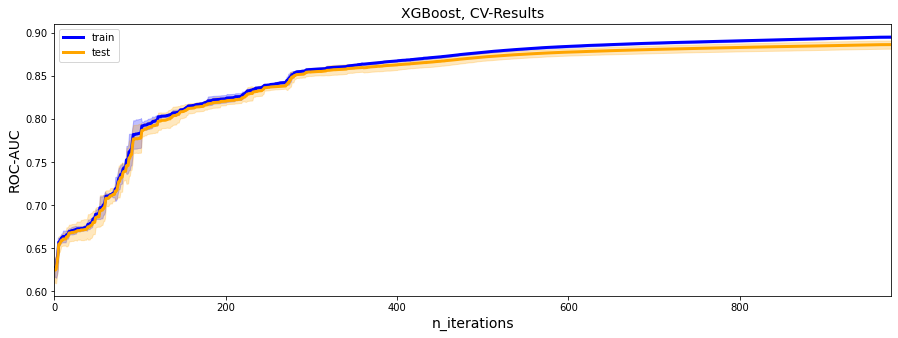

In [32]:
plotXgbResult(cv_xgb_num)

#### XGBoost - числовые и обработанные категориальные

In [33]:
%%time
model = train_xgb(params, prep_train, prep_valid, y_train, y_valid)

[0]	train-auc:0.64819	valid-auc:0.65529
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[250]	train-auc:0.84181	valid-auc:0.84847
[500]	train-auc:0.88333	valid-auc:0.88614
[750]	train-auc:0.89738	valid-auc:0.89762
[1000]	train-auc:0.90523	valid-auc:0.90272
Stopping. Best iteration:
[1143]	train-auc:0.90848	valid-auc:0.90497

Wall time: 42.8 s


In [34]:
%%time
# кросвалидация
cv_xgb_prep = cv_xgb(params, prep_train, y_train)

[0]	train-auc:0.62718+0.01094	test-auc:0.62467+0.01491
[250]	train-auc:0.84019+0.00111	test-auc:0.83730+0.00358
[500]	train-auc:0.88264+0.00097	test-auc:0.87638+0.00514
[750]	train-auc:0.89716+0.00113	test-auc:0.88894+0.00529
[1000]	train-auc:0.90448+0.00130	test-auc:0.89546+0.00555
[1250]	train-auc:0.90552+0.00153	test-auc:0.89637+0.00536
Wall time: 3min 41s


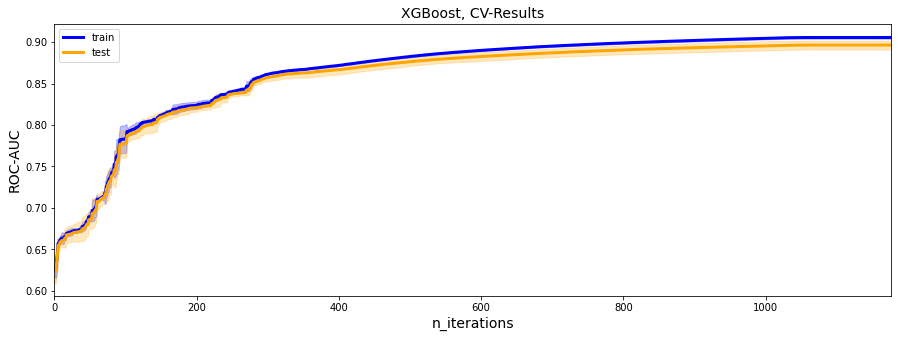

In [35]:
plotXgbResult(cv_xgb_prep)

### Вывод по XGBoost

Добавление предобработанных категорий повышает качество на 0,01 

## LightGBM


In [36]:
import lightgbm as lgb

In [37]:
def train_lgbm(params, x_train, x_valid, y_train, y_valid, cat_list='auto'):
    
    dtrain = lgb.Dataset(data=x_train, label=y_train)
    dvalid = lgb.Dataset(data=x_valid, label=y_valid)
    
    model = lgb.train(
        params=params,
        train_set=dtrain,
        num_boost_round=10000,
        early_stopping_rounds=50,
        valid_sets=[dtrain, dvalid],
        valid_names=["train", "valid"],
        verbose_eval=250,
        categorical_feature="auto",
    )
        
    return  model

In [38]:
def cv_lgbm(params, x_train, y_train, n_fold=5):
    dtrain = lgb.Dataset(data=x_train, label=y_train)
    cv_result = lgb.cv(
        params=params,
        train_set=dtrain,
        num_boost_round=10000,
        early_stopping_rounds=50,
        categorical_feature="auto",
        verbose_eval=250,
        stratified=True,
        metrics="auc",
        shuffle=True,
        nfold=n_fold,
        eval_train_metric=True
    )
    return cv_result

In [39]:
# ['train auc-mean', 'train auc-stdv', 'valid auc-mean', 'valid auc-stdv']
def plotLgbmResult(cv_result):
    res = pd.DataFrame.from_dict(cv_result)
    res.columns =['train-auc-mean', 'train-auc-std', 'test-auc-mean', 'test-auc-std']
    plotResult(res, 'LGBM')

In [40]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
#     "n_estimators": 250,
    'force_col_wise': True,
    "n_jobs": 6,
    "seed": 27
}
# params['device_type'] = 'gpu'
# params['gpu_platform_id'] = 0
# params['gpu_device_id'] = 1
# params['max_bin'] = 63
# params["boosting_type"] = "goss"

#### LGBM - числовые

In [41]:
%%time
# числовые данные
model = train_lgbm(params, num_train, num_valid, y_train, y_valid)

[LightGBM] [Info] Number of positive: 3856, number of negative: 131144
[LightGBM] [Info] Total Bins 31502
[LightGBM] [Info] Number of data points in the train set: 135000, number of used features: 376
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028563 -> initscore=-3.526666
[LightGBM] [Info] Start training from score -3.526666
Training until validation scores don't improve for 50 rounds
[250]	train's auc: 0.919784	valid's auc: 0.90989
[500]	train's auc: 0.944073	valid's auc: 0.923892
[750]	train's auc: 0.958927	valid's auc: 0.931948
[1000]	train's auc: 0.968498	valid's auc: 0.935959
[1250]	train's auc: 0.97535	valid's auc: 0.939246
[1500]	train's auc: 0.98008	valid's auc: 0.94146
[1750]	train's auc: 0.983133	valid's auc: 0.943078
[2000]	train's auc: 0.985748	valid's auc: 0.944398
[2250]	train's auc: 0.987976	valid's auc: 0.945346
[2500]	train's auc: 0.989686	valid's auc: 0.946687
[2750]	train's auc: 0.991408	valid's auc: 0.947639
[3000]	train's auc: 0.992604	valid's auc: 0.94858


In [42]:
%%time
# кросвалидация
cv_lgbm_num = cv_lgbm(params, num_train, y_train)

[LightGBM] [Info] Number of positive: 3085, number of negative: 104915
[LightGBM] [Info] Total Bins 31502
[LightGBM] [Info] Number of data points in the train set: 108000, number of used features: 376
[LightGBM] [Info] Number of positive: 3085, number of negative: 104915
[LightGBM] [Info] Total Bins 31502
[LightGBM] [Info] Number of data points in the train set: 108000, number of used features: 376
[LightGBM] [Info] Number of positive: 3085, number of negative: 104915
[LightGBM] [Info] Total Bins 31502
[LightGBM] [Info] Number of data points in the train set: 108000, number of used features: 376
[LightGBM] [Info] Number of positive: 3085, number of negative: 104915
[LightGBM] [Info] Total Bins 31502
[LightGBM] [Info] Number of data points in the train set: 108000, number of used features: 376
[LightGBM] [Info] Number of positive: 3084, number of negative: 104916
[LightGBM] [Info] Total Bins 31502
[LightGBM] [Info] Number of data points in the train set: 108000, number of used features:

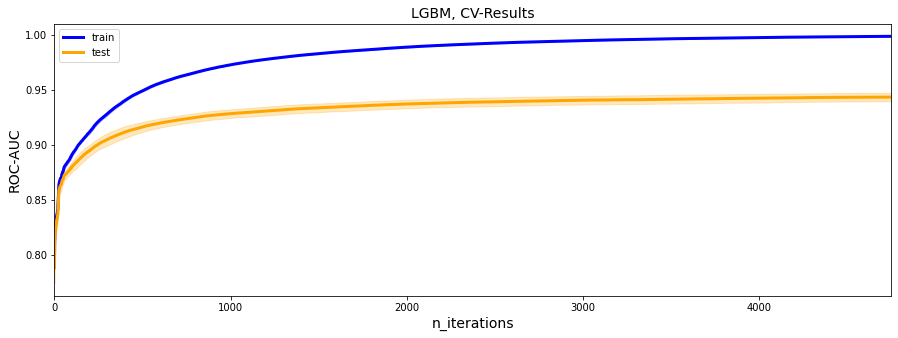

In [43]:
plotLgbmResult(cv_lgbm_num)

#### LGBM - числовые и обработанные категориальные

In [44]:
%%time
# num + cat подготовленнные
model = train_lgbm(params, prep_train, prep_valid, y_train, y_valid)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3856, number of negative: 131144
[LightGBM] [Info] Total Bins 31612
[LightGBM] [Info] Number of data points in the train set: 135000, number of used features: 427
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028563 -> initscore=-3.526666
[LightGBM] [Info] Start training from score -3.526666
Training until validation scores don't improve for 50 rounds
[250]	train's auc: 0.926076	valid's auc: 0.915467
[500]	train's auc: 0.953687	valid's auc: 0.931435
[750]	train's auc: 0.966088	valid's auc: 0.939394
[1000]	train's auc: 0.974936	valid's auc: 0.943624
[1250]	train's auc: 0.980555	valid's auc: 0.946428
[1500]	train's auc: 0.985039	valid's auc: 0.948929
[1750]	train's auc: 0.988615	valid's auc: 0.950649
[2000]	train's auc: 0.991141	valid's auc: 0.951843
[2250]	train's auc: 0.992877	valid's au

In [47]:
%%time
# кросвалидация
cv_lgbm_prep = cv_lgbm(params, prep_train, y_train)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3085, number of negative: 104915
[LightGBM] [Info] Total Bins 31612
[LightGBM] [Info] Number of data points in the train set: 108000, number of used features: 427
[LightGBM] [Info] Number of positive: 3085, number of negative: 104915
[LightGBM] [Info] Total Bins 31612
[LightGBM] [Info] Number of data points in the train set: 108000, number of used features: 427
[LightGBM] [Info] Number of positive: 3085, number of negative: 104915
[LightGBM] [Info] Total Bins 31612
[LightGBM] [Info] Number of data points in the train set: 108000, number of used features: 427
[LightGBM] [Info] Number of positive: 3085, number of negative: 104915
[LightGBM] [Info] Total Bins 31612
[LightGBM] [Info] Number of data points in the train set: 108000, number of used features: 427
[LightGBM] [Info] Number of positive: 3084, number of negative: 104916
[LightGBM] [Info] Total Bins 31612
[LightGBM]

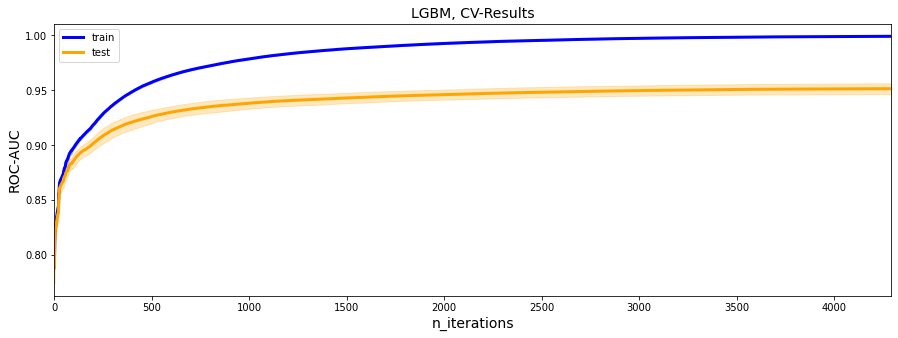

In [48]:
plotLgbmResult(cv_lgbm_prep)

#### LGBM данные с автоматической обработкой

In [45]:
def make_categoty_type(df):
    data = df.copy()
    for feature in CAT_F:
        print(feature, end=' ')
        data[feature] = pd.Series(data[feature], dtype="category")
    print()
    return data

In [46]:
lgbm_train = make_categoty_type(x_train)
lgbm_valid = make_categoty_type(x_valid)

ProductCD card4 card6 P_emaildomain R_emaildomain M1 M2 M3 M4 M5 M6 M7 M8 M9 
ProductCD card4 card6 P_emaildomain R_emaildomain M1 M2 M3 M4 M5 M6 M7 M8 M9 


In [49]:
%%time
# сырые данные с автоматической обработкой
model = train_lgbm(params, lgbm_train, lgbm_valid, y_train, y_valid, list(CAT_F))

[LightGBM] [Info] Number of positive: 3856, number of negative: 131144
[LightGBM] [Info] Total Bins 31666
[LightGBM] [Info] Number of data points in the train set: 135000, number of used features: 390


D:\_DL_PyTorch_\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
D:\_DL_PyTorch_\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028563 -> initscore=-3.526666
[LightGBM] [Info] Start training from score -3.526666
Training until validation scores don't improve for 50 rounds
[250]	train's auc: 0.927106	valid's auc: 0.917703
[500]	train's auc: 0.954525	valid's auc: 0.932758
[750]	train's auc: 0.96729	valid's auc: 0.940176
[1000]	train's auc: 0.975022	valid's auc: 0.943361
[1250]	train's auc: 0.980811	valid's auc: 0.945192
[1500]	train's auc: 0.985088	valid's auc: 0.946787
[1750]	train's auc: 0.988525	valid's auc: 0.948651
[2000]	train's auc: 0.990796	valid's auc: 0.950084
[2250]	train's auc: 0.992656	valid's auc: 0.951061
[2500]	train's auc: 0.994125	valid's auc: 0.952186
[2750]	train's auc: 0.995084	valid's auc: 0.952615
[3000]	train's auc: 0.995964	valid's auc: 0.953398
[3250]	train's auc: 0.996771	valid's auc: 0.954021
[3500]	train's auc: 0.997412	valid's auc: 0.954543
Early stopping, best iteration is:
[3642]	train's auc: 0.997758	valid's auc: 0.954835
Wall time

In [50]:
%%time
# кросвалидация
cv_lgbm_lgbm = cv_lgbm(params, lgbm_train, y_train)

[LightGBM] [Info] Number of positive: 3085, number of negative: 104915
[LightGBM] [Info] Total Bins 31666
[LightGBM] [Info] Number of data points in the train set: 108000, number of used features: 390
[LightGBM] [Info] Number of positive: 3085, number of negative: 104915
[LightGBM] [Info] Total Bins 31666
[LightGBM] [Info] Number of data points in the train set: 108000, number of used features: 390
[LightGBM] [Info] Number of positive: 3085, number of negative: 104915
[LightGBM] [Info] Total Bins 31666
[LightGBM] [Info] Number of data points in the train set: 108000, number of used features: 390
[LightGBM] [Info] Number of positive: 3085, number of negative: 104915
[LightGBM] [Info] Total Bins 31666
[LightGBM] [Info] Number of data points in the train set: 108000, number of used features: 390
[LightGBM] [Info] Number of positive: 3084, number of negative: 104916
[LightGBM] [Info] Total Bins 31666
[LightGBM] [Info] Number of data points in the train set: 108000, number of used features:

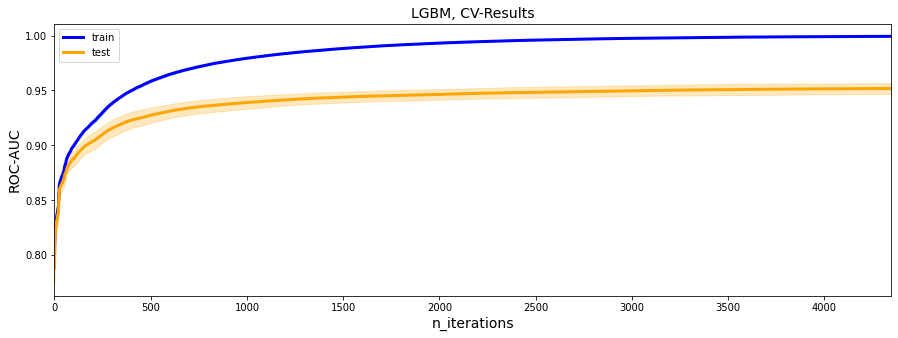

In [51]:
plotLgbmResult(cv_lgbm_lgbm)

## CatBoost

In [75]:
import catboost as cb

In [76]:
cat_f = list(CAT_F)

In [77]:
def train_catboost(params, x_train, x_valid, y_train, y_valid, cat_list=[]):
    
    model = cb.CatBoostClassifier(**cb_params)
    
    dtrain = cb.Pool(x_train, y_train, cat_features=cat_list)
    dvalid = cb.Pool(x_valid, y_valid, cat_features=cat_list)
    
    return model.fit(dtrain, eval_set=dvalid)

In [78]:
def cv_catboost(params, x_train, y_train, cat_list=[], n_fold=5):
    dtrain = cb.Pool(x_train, y_train, cat_features=cat_list)
    cv_result = cb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=5000,
        early_stopping_rounds=50,
        shuffle=True,
        nfold=n_fold,
        stratified=True,
        verbose = 250,
#         metric_period=50,
    )
    return cv_result

In [86]:
def plotCatBoostResult(cv_result):
    res = cv_result[['train-AUC-mean','train-AUC-std','test-AUC-mean', 'test-AUC-std']]
    res.columns =['train-auc-mean', 'train-auc-std', 'test-auc-mean', 'test-auc-std']
    plotResult(res, 'CatBoost')

In [79]:
cb_params = {
    "n_estimators": 10000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "custom_metric" : "AUC:hints=skip_train~false",
    "task_type": "GPU",
    "devices": '0:1',
    "max_bin": 64,
    "verbose": 250,
    "max_depth": 5,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

#### CatBoost - числовые

In [58]:
%%time
model = train_catboost(cb_params, num_train, num_valid, y_train, y_valid)

0:	learn: 0.6555312	test: 0.6661511	best: 0.6661511 (0)	total: 36.8ms	remaining: 6m 7s
250:	learn: 0.8755673	test: 0.8805734	best: 0.8805734 (250)	total: 8.11s	remaining: 5m 15s
500:	learn: 0.8846190	test: 0.8873058	best: 0.8873209 (497)	total: 16.2s	remaining: 5m 7s
750:	learn: 0.8890081	test: 0.8900202	best: 0.8900225 (749)	total: 25.2s	remaining: 5m 10s
1000:	learn: 0.8930180	test: 0.8924185	best: 0.8924185 (1000)	total: 33.6s	remaining: 5m 1s
1250:	learn: 0.8963589	test: 0.8943980	best: 0.8943980 (1250)	total: 41.7s	remaining: 4m 51s
1500:	learn: 0.8989106	test: 0.8955936	best: 0.8955936 (1500)	total: 50.6s	remaining: 4m 46s
1750:	learn: 0.9010214	test: 0.8966654	best: 0.8966655 (1749)	total: 59s	remaining: 4m 37s
2000:	learn: 0.9031421	test: 0.8977978	best: 0.8977978 (2000)	total: 1m 7s	remaining: 4m 29s
2250:	learn: 0.9052633	test: 0.8990270	best: 0.8990270 (2250)	total: 1m 16s	remaining: 4m 23s
2500:	learn: 0.9071612	test: 0.9001289	best: 0.9001289 (2500)	total: 1m 24s	remaining

In [80]:
%%time
# кросвалидация
cv_cboost_num = cv_catboost(cb_params, num_train, y_train)

0:	learn: 0.6185203	test: 0.6166786	best: 0.6166786 (0)
250:	learn: 0.8754069	test: 0.8714464	best: 0.8714497 (249)


500:	learn: 0.8889089	test: 0.8828842	best: 0.8828842 (500)


750:	learn: 0.8962368	test: 0.8888778	best: 0.8888778 (750)


1000:	learn: 0.9012234	test: 0.8927383	best: 0.8927383 (1000)	total: 8m 46s	remaining: 35m 4s


1250:	learn: 0.9050120	test: 0.8956072	best: 0.8956072 (1250)


1500:	learn: 0.9076267	test: 0.8974697	best: 0.8974697 (1500)


1750:	learn: 0.9097749	test: 0.8990240	best: 0.8990240 (1750)


2000:	learn: 0.9120233	test: 0.9006064	best: 0.9006064 (2000)


2250:	learn: 0.9138629	test: 0.9020259	best: 0.9020260 (2248)


2500:	learn: 0.9155242	test: 0.9031597	best: 0.9031597 (2500)


2750:	learn: 0.9170073	test: 0.9042259	best: 0.9042259 (2750)


3000:	learn: 0.9183885	test: 0.9052033	best: 0.9052052 (2998)


3250:	learn: 0.9194125	test: 0.9058479	best: 0.9058479 (3250)


3500:	learn: 0.9207440	test: 0.9067442	best: 0.9067442 (3500)
3750:	learn: 0.9220209	test: 0.9076320	best: 0.9076320 (3750)


4000:	learn: 0.9232090	test: 0.9084663	best: 0.9084663 (4000)


4250:	learn: 0.9243513	test: 0.9093007	best: 0.9093007 (4250)


4500:	learn: 0.9254627	test: 0.9101221	best: 0.9101221 (4500)
4750:	learn: 0.9264181	test: 0.9107149	best: 0.9107149 (4750)


4999:	learn: 0.9274288	test: 0.9113938	best: 0.9113939 (4998)	total: 39m 5s	remaining: 0us
Wall time: 39min 8s


In [82]:
cv_cboost_num.keys()

Index(['iterations', 'test-AUC-mean', 'test-AUC-std', 'train-AUC-mean',
       'train-AUC-std', 'test-Logloss-mean', 'test-Logloss-std',
       'train-Logloss-mean', 'train-Logloss-std'],
      dtype='object')

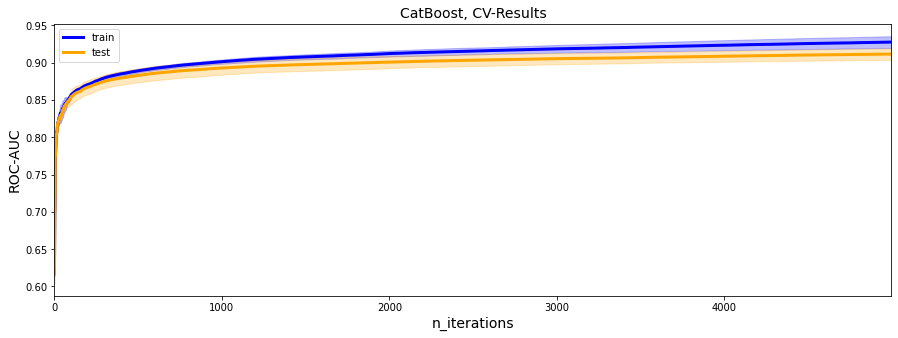

In [87]:
plotCatBoostResult(cv_cboost_num)

#### CatBoost - числовые и обработанные категориальные

In [89]:
%%time
model = train_catboost(cb_params, prep_train, prep_valid, y_train, y_valid)

0:	learn: 0.6555312	test: 0.6661511	best: 0.6661511 (0)	total: 31.2ms	remaining: 5m 12s
250:	learn: 0.8805874	test: 0.8856209	best: 0.8856209 (250)	total: 9.52s	remaining: 6m 9s
500:	learn: 0.8916422	test: 0.8939289	best: 0.8939289 (500)	total: 17.9s	remaining: 5m 38s
750:	learn: 0.8967364	test: 0.8975372	best: 0.8975394 (748)	total: 28.3s	remaining: 5m 48s
1000:	learn: 0.9009990	test: 0.9004506	best: 0.9004506 (1000)	total: 40.7s	remaining: 6m 5s
1250:	learn: 0.9038302	test: 0.9024147	best: 0.9024147 (1250)	total: 51.8s	remaining: 6m 2s
1500:	learn: 0.9065137	test: 0.9040969	best: 0.9040990 (1499)	total: 1m 2s	remaining: 5m 56s
1750:	learn: 0.9088554	test: 0.9053457	best: 0.9053486 (1749)	total: 1m 13s	remaining: 5m 47s
2000:	learn: 0.9113459	test: 0.9069597	best: 0.9069597 (2000)	total: 1m 25s	remaining: 5m 41s
2250:	learn: 0.9135022	test: 0.9082320	best: 0.9082320 (2250)	total: 1m 36s	remaining: 5m 30s
2500:	learn: 0.9155480	test: 0.9094180	best: 0.9094251 (2497)	total: 1m 47s	remai

In [90]:
%%time
# кросвалидация
cv_cboost_prep = cv_catboost(cb_params, prep_train, y_train)

0:	learn: 0.6185203	test: 0.6166786	best: 0.6166786 (0)
250:	learn: 0.8798090	test: 0.8748724	best: 0.8748724 (250)


500:	learn: 0.8954804	test: 0.8883799	best: 0.8883799 (500)


750:	learn: 0.9037286	test: 0.8952843	best: 0.8952843 (750)


1000:	learn: 0.9089835	test: 0.8993543	best: 0.8993543 (1000)


1250:	learn: 0.9129462	test: 0.9025564	best: 0.9025564 (1250)


1500:	learn: 0.9154660	test: 0.9044905	best: 0.9044905 (1500)


1750:	learn: 0.9177466	test: 0.9061693	best: 0.9061693 (1750)


2000:	learn: 0.9202051	test: 0.9080754	best: 0.9080754 (2000)
2250:	learn: 0.9220945	test: 0.9095764	best: 0.9095764 (2250)


2500:	learn: 0.9237014	test: 0.9107885	best: 0.9107910 (2499)
2750:	learn: 0.9249061	test: 0.9116058	best: 0.9116099 (2747)


3000:	learn: 0.9259721	test: 0.9123558	best: 0.9123558 (3000)


3250:	learn: 0.9269453	test: 0.9130236	best: 0.9130236 (3250)


3500:	learn: 0.9283873	test: 0.9140577	best: 0.9140577 (3500)


3750:	learn: 0.9297025	test: 0.9150996	best: 0.9150996 (3750)


4000:	learn: 0.9306994	test: 0.9157884	best: 0.9157890 (3999)


4250:	learn: 0.9317109	test: 0.9165812	best: 0.9165812 (4250)
4500:	learn: 0.9327960	test: 0.9173284	best: 0.9173284 (4500)


4750:	learn: 0.9338874	test: 0.9181403	best: 0.9181403 (4750)


4999:	learn: 0.9350932	test: 0.9189888	best: 0.9189888 (4999)	total: 36m 30s	remaining: 0us
Wall time: 36min 33s


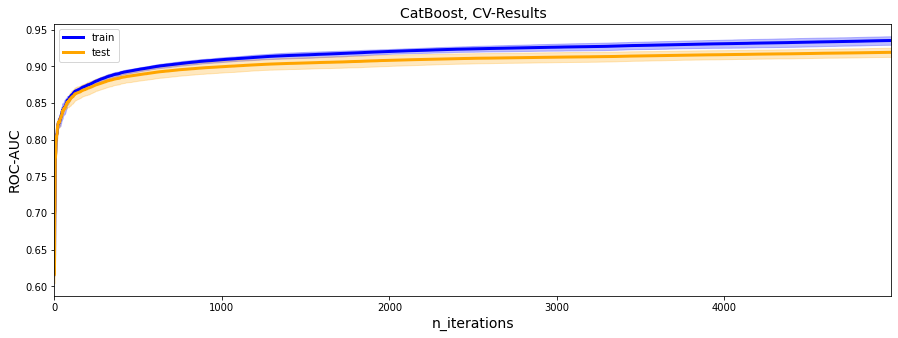

In [91]:
plotCatBoostResult(cv_cboost_prep)

#### CatBoost данные с автоматической обработкой

In [92]:
def make_categoty_str_type(df):
    data = df.copy()
    for feature in CAT_F:
        print(feature, end=' ')
        data[feature] = pd.Series(data[feature], dtype='str')
    print()
    return data

In [93]:
cb_train = make_categoty_str_type(x_train)
cb_valid = make_categoty_str_type(x_valid)

ProductCD card4 card6 P_emaildomain R_emaildomain M1 M2 M3 M4 M5 M6 M7 M8 M9 
ProductCD card4 card6 P_emaildomain R_emaildomain M1 M2 M3 M4 M5 M6 M7 M8 M9 


In [94]:
%%time
model = train_catboost(cb_params, cb_train, cb_valid, y_train, y_valid, cat_list=cat_f)

0:	learn: 0.6958504	test: 0.7142413	best: 0.7142413 (0)	total: 63.5ms	remaining: 10m 35s
250:	learn: 0.8479461	test: 0.8509021	best: 0.8509021 (250)	total: 14.5s	remaining: 9m 24s
500:	learn: 0.8740121	test: 0.8750731	best: 0.8750741 (499)	total: 29.4s	remaining: 9m 16s
750:	learn: 0.8838048	test: 0.8836241	best: 0.8836241 (748)	total: 44.2s	remaining: 9m 4s
1000:	learn: 0.8883788	test: 0.8877838	best: 0.8877931 (995)	total: 59.4s	remaining: 8m 53s
1250:	learn: 0.8912615	test: 0.8900560	best: 0.8900565 (1246)	total: 1m 16s	remaining: 8m 53s
1500:	learn: 0.8937542	test: 0.8919634	best: 0.8919634 (1500)	total: 1m 35s	remaining: 9m 3s
1750:	learn: 0.8963845	test: 0.8940465	best: 0.8940469 (1748)	total: 1m 51s	remaining: 8m 44s
2000:	learn: 0.8980812	test: 0.8953263	best: 0.8953409 (1979)	total: 2m 7s	remaining: 8m 27s
2250:	learn: 0.9000906	test: 0.8970711	best: 0.8970711 (2249)	total: 2m 22s	remaining: 8m 9s
2500:	learn: 0.9014409	test: 0.8981109	best: 0.8981109 (2500)	total: 2m 37s	rema

In [95]:
%%time
# кросвалидация
cv_cboost_cb = cv_catboost(cb_params,  cb_train, y_train, cat_list=cat_f)

0:	learn: 0.6712613	test: 0.6719733	best: 0.6719733 (0)
250:	learn: 0.8478008	test: 0.8487680	best: 0.8487680 (250)


500:	learn: 0.8596813	test: 0.8589892	best: 0.8589892 (500)


750:	learn: 0.8727551	test: 0.8709479	best: 0.8709479 (750)


1000:	learn: 0.8810181	test: 0.8783269	best: 0.8783269 (1000)


1250:	learn: 0.8857135	test: 0.8824183	best: 0.8824183 (1250)


1500:	learn: 0.8900006	test: 0.8860987	best: 0.8860987 (1500)


1750:	learn: 0.8935294	test: 0.8890846	best: 0.8890846 (1750)


2000:	learn: 0.8959699	test: 0.8909395	best: 0.8909442 (1998)
2250:	learn: 0.8980872	test: 0.8926621	best: 0.8926621 (2250)


2500:	learn: 0.9001226	test: 0.8943662	best: 0.8943662 (2500)


2750:	learn: 0.9020826	test: 0.8960780	best: 0.8960788 (2748)


3000:	learn: 0.9034949	test: 0.8971795	best: 0.8971795 (3000)


3250:	learn: 0.9048124	test: 0.8982024	best: 0.8982024 (3250)


3500:	learn: 0.9061246	test: 0.8992493	best: 0.8992493 (3500)


3750:	learn: 0.9074232	test: 0.9003260	best: 0.9003260 (3750)
4000:	learn: 0.9084106	test: 0.9011223	best: 0.9011223 (4000)


4250:	learn: 0.9092467	test: 0.9018485	best: 0.9018485 (4250)


4500:	learn: 0.9099963	test: 0.9024911	best: 0.9024911 (4500)


4750:	learn: 0.9107778	test: 0.9031111	best: 0.9031133 (4748)


4999:	learn: 0.9114967	test: 0.9037179	best: 0.9037185 (4997)	total: 44m 3s	remaining: 0us
Wall time: 44min 6s


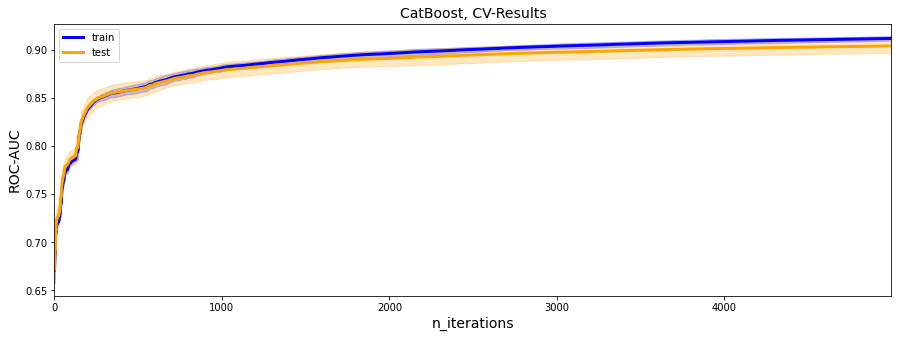

In [96]:
plotCatBoostResult(cv_cboost_cb)

## Графики и выводы

### Числовые данные

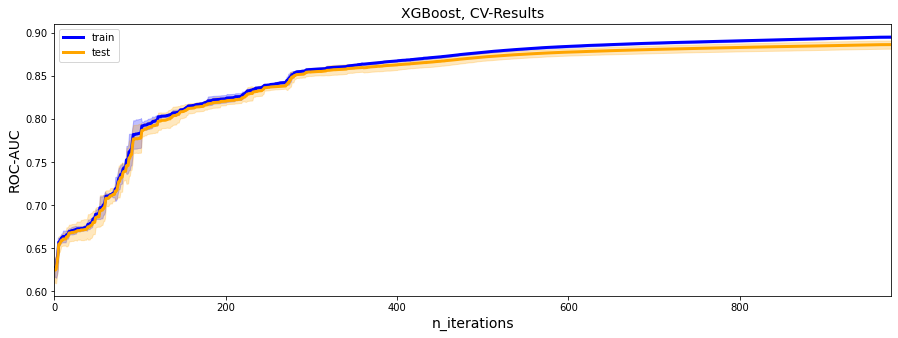

In [98]:
# XGBoost
plotXgbResult(cv_xgb_num)

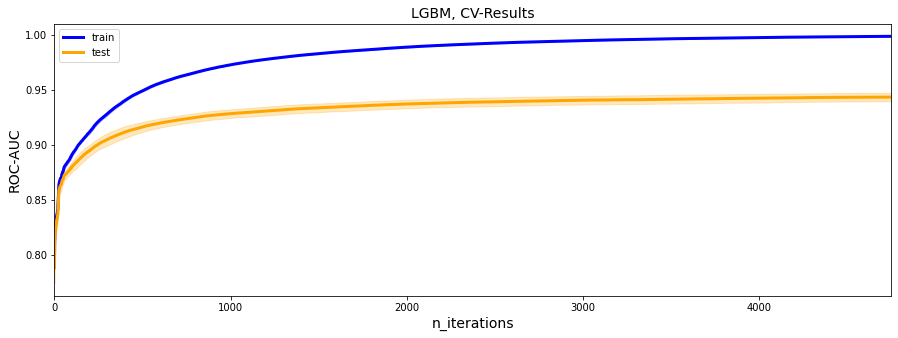

In [99]:
# LighGBM
plotLgbmResult(cv_lgbm_num)

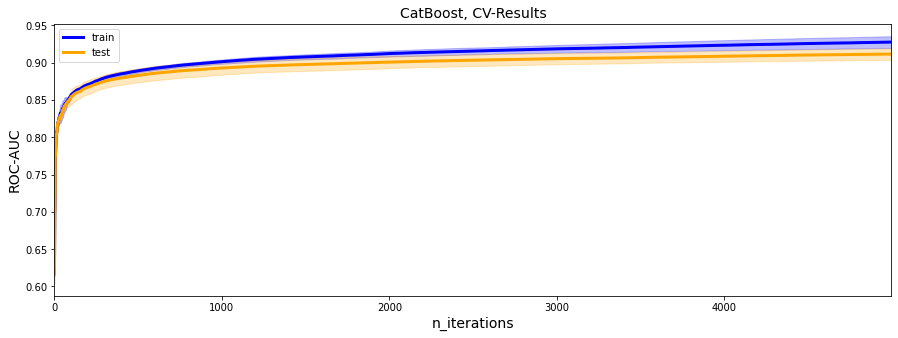

In [100]:
# CatBoost
plotCatBoostResult(cv_cboost_num)

#### Выводы для числовых данных

* LGBM и CatBoost учатся плавно, в отличии от XgBoost
* LGBM - большая разница между метрикой на Train и  Valid выборках
* CatBoost имеет больший разброс значений метрики на CV среди всех алгоритмов

Лучший результат: LightGBM 0.943551 + 0.00381884

### Предобработанные данные

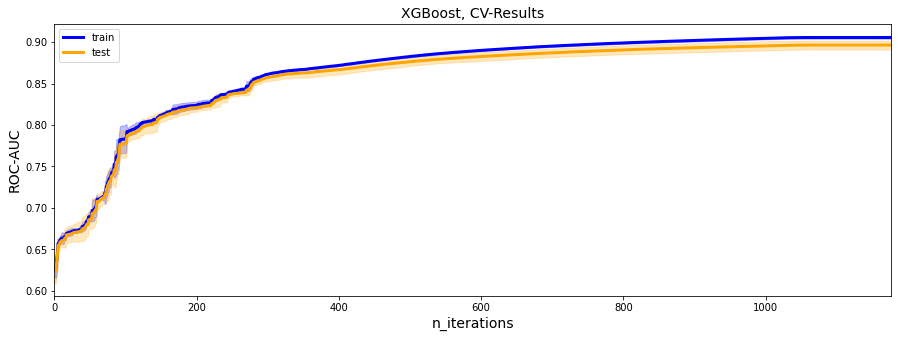

In [101]:
# XGBoost
plotXgbResult(cv_xgb_prep)

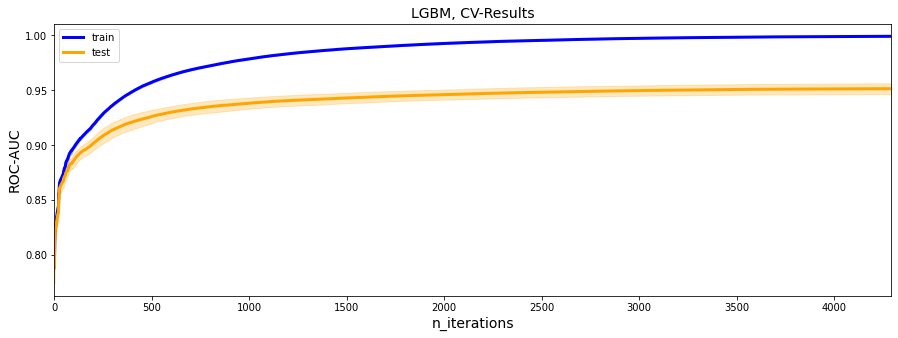

In [102]:
# LighGBM
plotLgbmResult(cv_lgbm_prep)

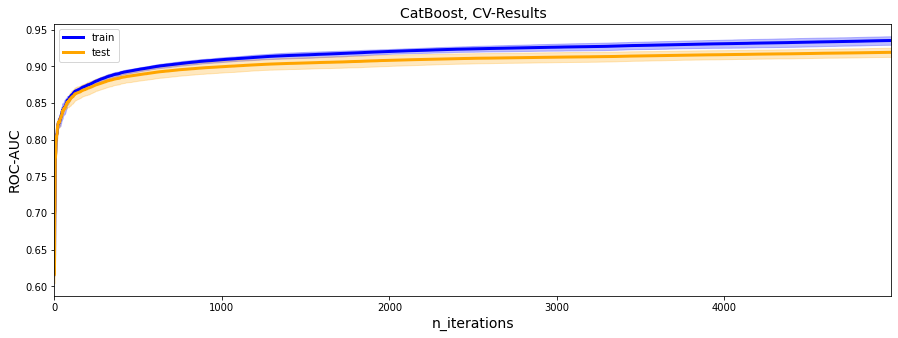

In [103]:
# CatBoost
plotCatBoostResult(cv_cboost_prep)

#### Выводы для предобработанных данных

Выводы такие же что и на числовых, только увеличилась точность ( значение метрики ) во всех алгоритмах

* LGBM и CatBoost учатся плавно, в отличии от XgBoost
* LGBM - большая разница между метрикой на Train и  Valid выборках
* CatBoost имеет больший разброс значений метрики на CV среди всех алгоритмов

Лучший результат: LightGBM 0.95149 + 0.0049092

### Сырые данные

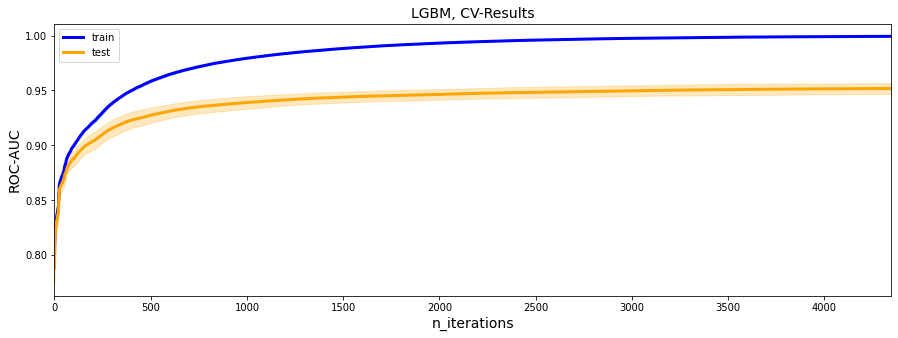

In [104]:
# LighGBM
plotLgbmResult(cv_lgbm_lgbm)

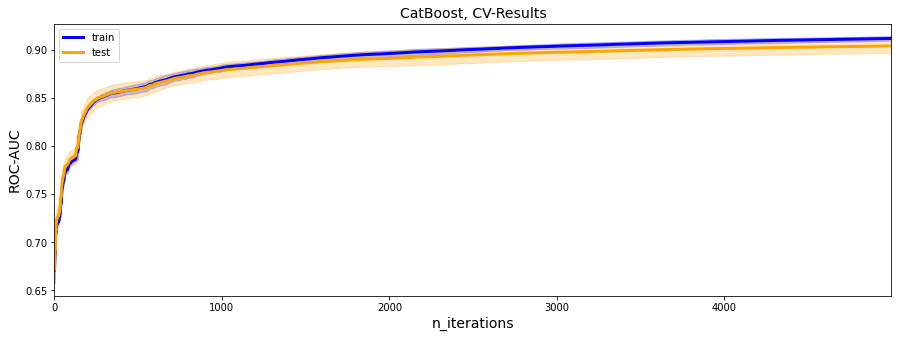

In [105]:
# CatBoost
plotCatBoostResult(cv_cboost_cb)

#### Выводы для числовых данных

* LGBM - сохранил свою плавность обучения и увеличил точность
* CatBoost - утратил плавность в начале обучения. Также увеличил точность по сравнению с числовыми данными

Лучший результат: LightGBM 0.951652 + 0.00493086

В данном исследовании лучше всего по метрике показала себя LightGBM. Возможно это потому, что это единственный алгоритм который обучался на процессоре. К сожалению я не смог запустить (перекомпилировать) Lgbm под Windows для работе на GPU